In [1]:
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

In [2]:
from reader import read_data_preprocessed

X, y = read_data_preprocessed()

In [3]:
X = X.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [4]:
def weight(S_mu: float) -> float:
    BASE = 1
    TARGET = 3
    TARGET_S_MU = 60
    return BASE + TARGET * (S_mu / TARGET_S_MU)

dtrain = xgb.DMatrix(X_train, label=y_train, weight=np.array([weight(S_mu) for S_mu in y_train]))
dtest = xgb.DMatrix(X_test, label=y_test, weight=np.array([weight(S_mu) for S_mu in y_test]))

In [5]:
param = {
    'max_depth': 8,
    'learning_rate': 0.1,
    'min_child_weight': 3.0,
    'subsample': 0.8,
    'objective': 'reg:squarederror',
}

epochs = 500

In [6]:
model = xgb.train(param, dtrain, num_boost_round=epochs, evals=[(dtest, 'test')], verbose_eval=5, early_stopping_rounds=15)

[0]	test-rmse:9.45519
[5]	test-rmse:6.98455
[10]	test-rmse:5.84551
[15]	test-rmse:5.37080
[20]	test-rmse:5.17745
[25]	test-rmse:5.10503
[30]	test-rmse:5.07702
[35]	test-rmse:5.06267
[40]	test-rmse:5.05538
[45]	test-rmse:5.05197
[50]	test-rmse:5.04967
[55]	test-rmse:5.04926
[60]	test-rmse:5.05044
[65]	test-rmse:5.04914
[70]	test-rmse:5.04847
[75]	test-rmse:5.04793
[80]	test-rmse:5.04635
[85]	test-rmse:5.04715
[90]	test-rmse:5.04769
[92]	test-rmse:5.04635


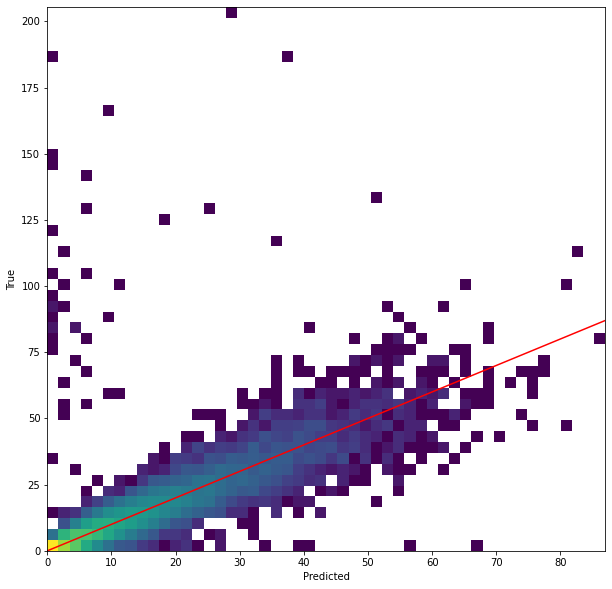

<Figure size 432x288 with 0 Axes>

In [7]:
y_pred = model.predict(dtest)
y_pred = np.maximum(y_pred, 0)
y_true = dtest.get_label()

from matplotlib.colors import LogNorm

fig, ax = plt.subplots(figsize=(10, 10))

ax.hist2d(y_pred, y_true, bins=50, norm=LogNorm())
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
y_max = max(y_pred.max(), y_true.max())
ax.plot([0, y_max], [0, y_max], color='red')

plt.show()

plt.savefig(f"../pics/xgboost-evaluation-absvalues-{param['objective']}.png", bbox_inches='tight')

# Prediction error

In [11]:
N_BINS = 25
QUANTILE = 0.05
MAX_S_MU = 70

In [12]:
bin_edges = np.linspace(0, MAX_S_MU, N_BINS + 1)

# fig, axes = plt.subplots(nrows=1, ncols=N_BINS, figsize=(30, 2))

predicted = []
true_mean = []
true_lower_cl = []
true_upper_cl = []

for idx, (bin_edge_l, bin_edge_r) in enumerate(zip(bin_edges[:-1], bin_edges[1:])):
    predicted_in_range_mask = np.logical_and(y_pred >= bin_edge_l, y_pred <= bin_edge_r)
    true_for_predicted_in_range = y_true[predicted_in_range_mask]
    if not true_for_predicted_in_range.size:
        continue
    # ax: plt.Axes = axes[idx]
    # ax.hist(true_for_predicted_in_range)
    # ax.set_xticklabels([])
    # ax.set_yticklabels([])
    predicted.append(0.5 * (bin_edge_l + bin_edge_r))
    true_mean.append(np.mean(true_for_predicted_in_range))
    true_lower_cl.append(np.quantile(true_for_predicted_in_range, QUANTILE))
    true_upper_cl.append(np.quantile(true_for_predicted_in_range, 1 - QUANTILE))

predicted = np.array(predicted)
true_mean = np.array(true_mean)
true_lower_cl = np.array(true_lower_cl)
true_upper_cl = np.array(true_upper_cl)

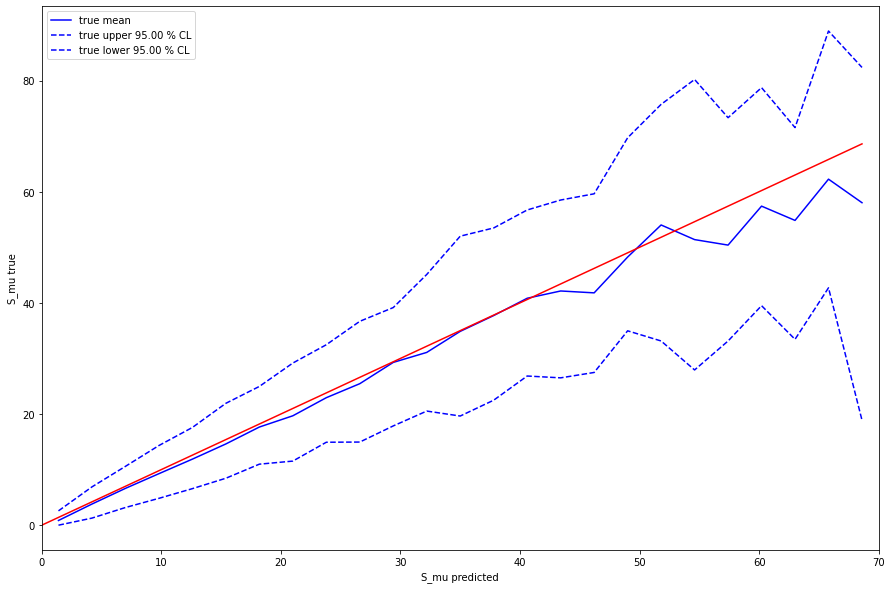

In [13]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(predicted, true_mean, 'b-', label="true mean")
cl_label = f"{100 * (1 - QUANTILE):.2f} %"
ax.plot(predicted, true_upper_cl, 'b--', label=f"true upper {cl_label} CL")
ax.plot(predicted, true_lower_cl, 'b--', label=f"true lower {cl_label} CL")
ax.plot([0, predicted[-1]], [0, predicted[-1]], color='red')
ax.set_xlim(0, MAX_S_MU)
ax.set_xlabel(r"S_mu predicted")
ax.set_ylabel(r"S_mu true")
ax.legend()